In [3]:
import time
import importlib

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy.stats import pearsonr

import tensorflow as tf
from Modules import utils, tf_utils, plot_utils
from Modules.tf_utils import mae_cor, correlate

In [4]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [5]:
with np.load(Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz')) as f:
    x_train = f['chr02']
    x_valid = f['chr01']
    x_test = f['chr03']
with np.load(Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz')) as f:
    y_train = f['chr02']
    y_valid = f['chr01']
    y_test = f['chr03']
x_train.shape

(844051, 4)

In [10]:
def valid_windows(one_hot_chr, labels, winsize):
    N_mask = (np.sum(one_hot_chr, axis=1) == 0)
    N_window_mask = np.asarray(
        np.convolve(N_mask, np.ones(winsize), mode='same'),
        dtype=int)
    valid_window_mask = (N_window_mask == 0) & (labels != 0).ravel()
    indexes = np.arange(len(one_hot_chr))[valid_window_mask]
    indexes = indexes[
        (indexes >= winsize // 2)
        & (indexes < len(one_hot_chr) - (winsize // 2))]
    return indexes

In [16]:
x_eff = valid_windows(x_valid, y_valid, 2001)
len(x_eff)

238115

In [17]:
gen_x = tf_utils.WindowGenerator(x_valid, y_valid, 2001, 1024, 2**22)
gen_x.max_data

238115

In [15]:
2**20

1048576

In [6]:
def predict(model, one_hot_chr, winsize=2001):
    X = utils.chunk_chr(one_hot_chr, 2001)[1]
    pred = np.zeros(len(one_hot_chr))
    pred[winsize//2:-(winsize//2)] = model.predict(X)[:, 0]
    return pred

In [7]:
model = tf.keras.models.load_model(Path(data_dir, 'SCerevisiae', 'Trainedmodels', 'model_mnase_2', 'model'), custom_objects={"mae_cor": mae_cor, "correlate": correlate})
pred_test = predict(model, x_test)
pred_valid = predict(model, x_valid)
pred_train = predict(model, x_train)
pred_test_rev = predict(model, x_test[::-1,::-1])[::-1]
pred_valid_rev = predict(model, x_valid[::-1,::-1])[::-1]
pred_train_rev = predict(model, x_train[::-1,::-1])[::-1]
del model

2023-03-09 14:40:50.466271: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-09 14:40:50.536801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 14:40:50.536986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-09 14:40:50.537047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-09 14:40:50.537187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

In [19]:
test_corrs = np.corrcoef([y_test, pred_test, pred_test_rev])
valid_corrs = np.corrcoef([y_valid, pred_valid, pred_valid_rev])
train_corrs = np.corrcoef([y_train, pred_train, pred_train_rev])
test_corrs, valid_corrs, train_corrs

(array([[1.        , 0.57081365, 0.5822789 ],
        [0.57081365, 1.        , 0.66006644],
        [0.5822789 , 0.66006644, 1.        ]]),
 array([[1.        , 0.56816693, 0.56442126],
        [0.56816693, 1.        , 0.62536211],
        [0.56442126, 0.62536211, 1.        ]]),
 array([[1.        , 0.8913237 , 0.57227383],
        [0.8913237 , 1.        , 0.62596317],
        [0.57227383, 0.62596317, 1.        ]]))

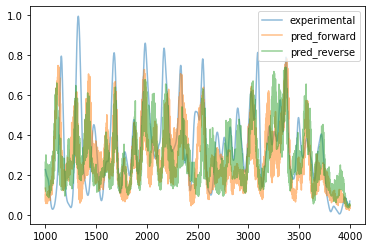

In [25]:
start = 1000
stop = start + 3000 # len(pred_train)
plt.plot(np.arange(start, stop), y_test[start:stop], label='experimental', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test[start:stop], label='pred_forward', alpha=0.5)
plt.plot(np.arange(start, stop), pred_test_rev[start:stop], label='pred_reverse', alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [36]:
def merge_chroms(chr_ids, file):
    annot = []
    with np.load(file) as f:
        for chr_id in chr_ids:
            annot.append(f[chr_id])
            shape, dtype = f[chr_id].shape, f[chr_id].dtype
            annot.append(np.zeros((1,)+shape[1:], dtype=dtype))
    return np.concatenate(annot)

In [43]:
a = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'genome', 'W303', 'W303.npz'))
a.shape

(9409640, 4)

In [44]:
b = merge_chroms(['chr01', 'chr02', 'chr03', 'chr04', 'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10', 'chr11', 'chr12', 'chr13'], Path(data_dir, 'SCerevisiae', 'data', 'processed_MNase.npz'))
b.shape

(9409640,)

: 